# Implementing ZFNet original paper

## Creating the ZFNet model

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation
import numpy as np

np.random.seed(42)

In [3]:
# Initialize ZFNet model
ZFnet = Sequential([
    # Convolution layer 1                  
    Conv2D(filters=96, kernel_size=(7,7), strides=(2,2), padding='same', input_shape=(32,32,3)), # Original paper used 224x224x3 image size but we are using CIFAR100 dataset which contains only 32x32 images
    Activation(activation='relu'),
    tf.keras.layers.Lambda(tf.nn.local_response_normalization, arguments={'depth_radius':5, 'bias':2, 'alpha':0.0001, 'beta':0.75}),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),

    # Convolution layer 2
    Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same'),
    Activation(activation='relu'),
    tf.keras.layers.Lambda(tf.nn.local_response_normalization, arguments={'depth_radius':5, 'bias':2, 'alpha':0.0001, 'beta':0.75}),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),

    # Convolution layer 3
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    Activation(activation='relu'),

    # Convolution layer 4
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    Activation(activation='relu'),

    # Convolution layer 5
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    Activation(activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),

    # Fully-Connected layer 1
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dropout(rate=0.5),

    # Fully-Connected layer 2
    Dense(units=4096, activation='relu'),
    Dropout(rate=0.5),

    # Output layer
    Dense(units=100, activation='softmax')
]);


# Model summary
ZFnet.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 96)        14208     
_________________________________________________________________
activation (Activation)      (None, 16, 16, 96)        0         
_________________________________________________________________
lambda (Lambda)              (None, 16, 16, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 256)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 4, 4, 256)         0

In [5]:
ZFnet.save("drive/My Drive/Colab Notebooks/ZFnet.keras")

## Preparing the dataset

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 6s 0us/step


In [7]:
from keras.utils import to_categorical

print("Training set", X_train.shape, y_train.shape)
print("Test set", X_test.shape, y_test.shape)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Training set", X_train.shape, y_train.shape)
print("Test set", X_test.shape, y_test.shape)

Training set (50000, 32, 32, 3) (50000, 1)
Test set (10000, 32, 32, 3) (10000, 1)
Training set (50000, 32, 32, 3) (50000, 100)
Test set (10000, 32, 32, 3) (10000, 100)


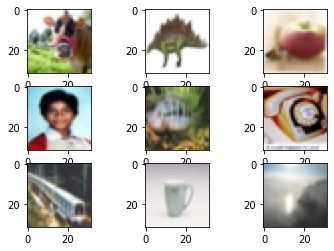

In [8]:
import matplotlib.pyplot as plt
for i in range(9) :
    plt.subplot(330+1+i)
    plt.imshow(X_train[i])
plt.show()

### Image Data Augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=2, 
                                     horizontal_flip=True, 
                                     zoom_range=0.1)

test_generator = ImageDataGenerator(rotation_range=2, 
                                     horizontal_flip=True, 
                                     zoom_range=0.1)

train_generator.fit(X_train)
test_generator.fit(X_test)

## Compiling and running the model and visualizing the results

In [11]:
from keras.losses import categorical_crossentropy

ZFnet.compile(loss = categorical_crossentropy, 
                optimizer = 'adam',
                metrics = ['accuracy'])

In [12]:
!pip install livelossplot

In [13]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

lrr = ReduceLROnPlateau(monitor="loss", mode='min', patience=5)
es = EarlyStopping(patience=10, monitor="loss", mode='min')

batch_size = 128
epochs = 100
lr = 0.01

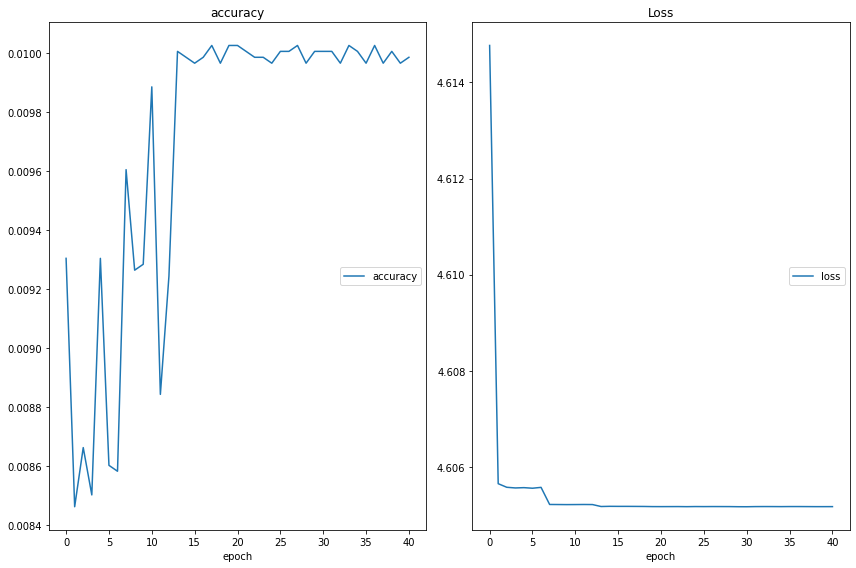

accuracy
	accuracy         	 (min:    0.008, max:    0.010, cur:    0.010)
Loss
	loss             	 (min:    4.605, max:    4.615, cur:    4.605)
390/390 [==============================] - 23s 59ms/step - loss: 4.6052 - accuracy: 0.0100


In [14]:
ZFnet.fit(x=train_generator.flow(X_train, y_train, batch_size=batch_size),
            epochs = epochs,
            steps_per_epoch=X_train.shape[0]//batch_size,
            callbacks=[PlotLossesKeras(), lrr, es],
            verbose=1)

### Evaluating the model on test-set

In [15]:
ZFnet.evaluate(x=test_generator.flow(X_test, y_test, batch_size=batch_size),
                 verbose=1)

79/79 [==============================] - 4s 53ms/step - loss: 4.6052 - accuracy: 0.0100


[4.605172634124756, 0.009999999776482582]